In [1]:
from random import sample
from os.path import splitext
from collections import Counter
import pandas as pd
import numpy as np
import rpy2.robjects as robj
import gzip
#import pybedtools
import regex
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

%load_ext rpy2.ipython
robj.pandas2ri.activate()

g4file = ('/home/matthew/Documents/analysis_notebooks/tair10_g4_prediction/'
          'tair10_g4s/tair10_2_6t_1_7l_0b.bed')
g4file_2t_only = '/tmp/tair10_2t.bed'
!grep "_2t_" {g4file} > {g4file_2t_only}

x_nodes = y_nodes = 6

# Using Self Organising Maps to determine which types of G4s are enriched in different areas of the Arabidopsis Genome

* G4s were predicted using tetrad length >=3 and loop length 1-7, and allowing for up to 2 bulges of length 1-5.
* The properties of these G4s were clustering using Self Organising Maps (SOM) in the kohonen package in R
* G4s which fall in genic regions on each strand are extracted from the data, and the enrichment of these G4s in particular nodes of the SOM are calculated to see if particular G4 types are enriched in particular locations.

### TO DO:
* Modify g4predict so that g4 properties include frequencies of A, C, and T in the loops/bulges, add this data to SOM.
* Use the list of genes up/downregulated by NMM to extract G4s inside NMM regulated genes, and see if NMM binds to a particular subset of G4s more strongly

In [2]:
def get_g4_properties(bed_file):
    if splitext(bed_file)[1] == '.gz':
        o_method = gzip.open
    else:
        o_method = open
    with o_method(bed_file, mode='rt') as bedfile:
        g4_data = []
        index = []
        for record in bedfile:
            chrom, start, stop, metadata, score, strand = record.split()
            barcode, tet, *loops, bulge1, bulge2, b_pos1, b_pos2 = metadata.split('_')
            b_pos = (b_pos1, b_pos2)
            tet = int(tet[0])
            loops = [int(l[0]) for l in loops]
            bulges = [int(bulge1), int(bulge2[0])]
            b_pos = [int(b) for b in b_pos]
            b_len_pos = [0 for _ in range(4)]
            for i, b in enumerate(b_pos):
                b_len_pos[b-1] = bulges[i]
            g4_data.append([tet,] + loops + b_len_pos)
            index.append(barcode)
    g4_data = pd.DataFrame(g4_data,
                           index=index,
                           columns=['tetrads', 'loop1', 'loop2',
                                    'loop3', 'bulge1', 'bulge2', 'bulge3', 'bulge4'])
    return g4_data

In [3]:
g4_data = get_g4_properties(g4file_2t_only)
g4_data.drop(['tetrads', 'bulge1', 'bulge2', 'bulge3', 'bulge4'], axis=1, inplace=True)
g4_data['total_loop_length'] = g4_data.sum(1)
g4_data.head()

,loop1,loop2,loop3,total_loop_length
PG00234229,5,5,2,12
PG00234231,1,7,7,15
PG00234232,6,4,3,13
PG00234233,4,5,3,12
PG00234234,6,5,4,15


In [6]:
%%R
library(kohonen)
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRblas.so
LAPACK: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] kohonen_3.0.6

loaded via a namespace (and not attached):
[1] MASS_7.3-48    compiler_3.4.1 Rcpp_0.12.15  


/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: class

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)


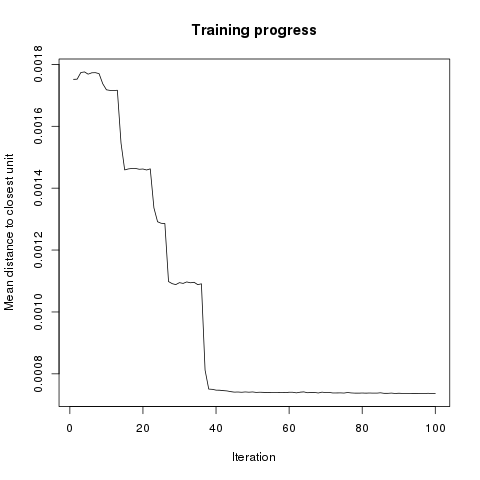

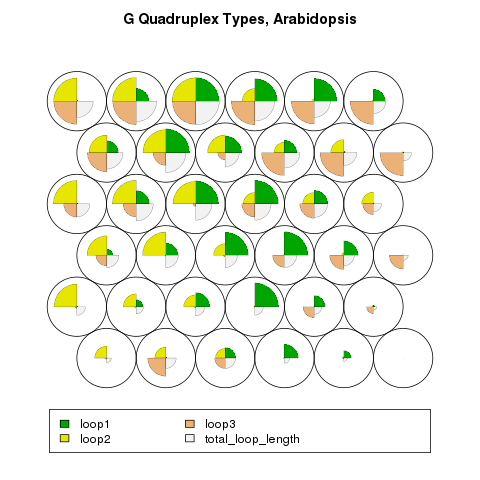

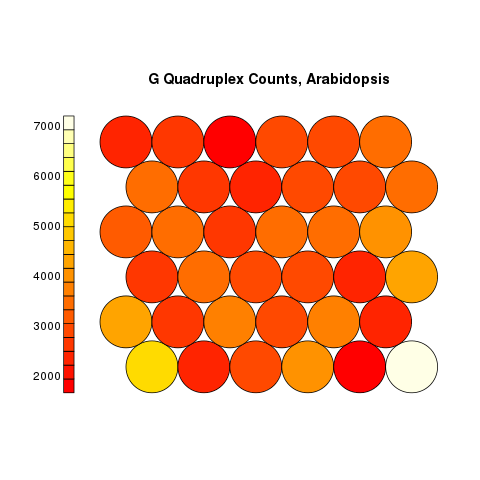

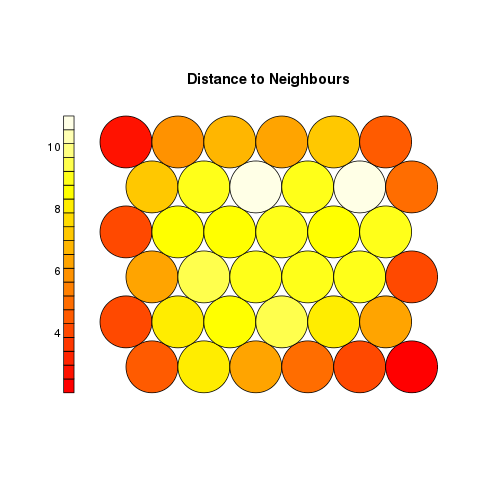

In [4]:
%%R -i g4_data,x_nodes,y_nodes
library(kohonen)
g4_data.scaled <- scale(g4_data)
g4_data.som <- som(data = g4_data.scaled, grid = somgrid(x_nodes, y_nodes, "hexagonal"))
plot(g4_data.som, type="changes")
plot(g4_data.som, type='codes', main='G Quadruplex Types, Arabidopsis')
plot(g4_data.som, type='count', main='G Quadruplex Counts, Arabidopsis')
plot(g4_data.som, type='dist.neighbours', main='Distance to Neighbours')

# Distribution of properties across the SOM

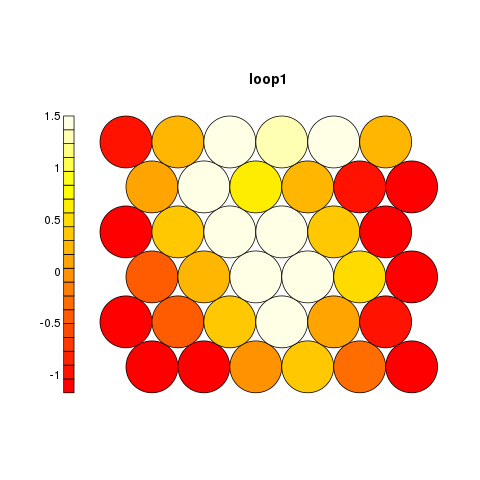

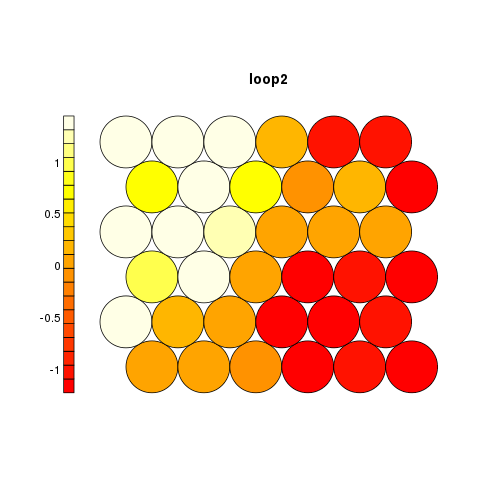

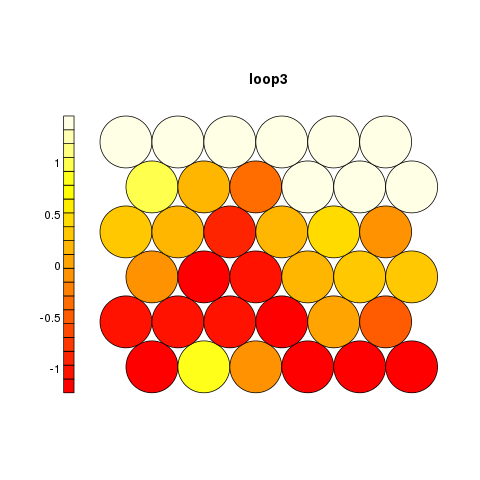

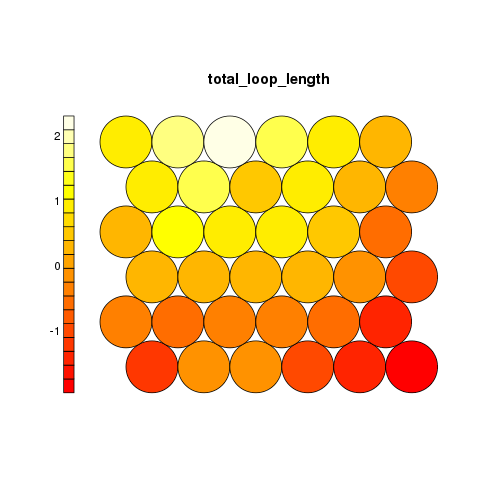

In [6]:
%%R
plot_property <- function(var) {
    plot(g4_data.som, type='property', property=g4_data.som$codes[,var], main=names(g4_data)[var])
}
t <- lapply(1:4, FUN=plot_property)

In [7]:
%R -o classifications classifications <- as.vector(g4_data.som$unit.classif)
%R -o grid grid <- g4_data.som$grid$pts
g4_data['cluster'] = classifications - 1
g4_data.head()

,loop1,loop2,loop3,total_loop_length,cluster
PG00234229,5,5,2,12,26
PG00234231,1,7,7,15,30
PG00234232,6,4,3,13,21
PG00234233,4,5,3,12,26
PG00234234,6,5,4,15,21


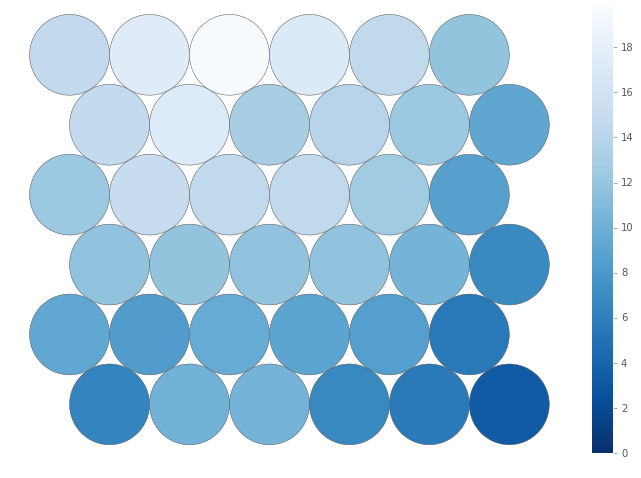

In [8]:
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

loop_length_means = np.asarray([
    g4_data[g4_data.cluster==n].total_loop_length.mean() for n in range(
        x_nodes * y_nodes)])
color_range = (0, loop_length_means.max())
colormap = ScalarMappable(Normalize(*color_range), cmap='Blues_r')
colormap.set_array(loop_length_means)

fig, ax = plt.subplots(figsize=(12, 8))
for length, xy in zip(loop_length_means, grid):
    cluster_circle = Circle(xy, radius=0.5,
                            facecolor=colormap.to_rgba(length),
                            edgecolor='#555555')
    ax.add_patch(cluster_circle)
ax.set(xlim=(grid[:,0].min()-0.6, grid[:,0].max()+0.6),
       ylim=(grid[:,1].min()-0.6, grid[:,1].max()+0.6))
ax.set_axis_off()
plt.colorbar(colormap)
plt.show()

In [9]:
def get_cluster_enrichment(bedtool, it=1000, subset_barcodes=None):
    if subset_barcodes is not None:
        g4_properties = g4_data.loc[subset_barcodes]
    else:
        g4_properties = g4_data
    properties = get_g4_properties(bedtool.fn)
    barcodes = list(properties.index.values)
    cluster_counts = Counter(g4_properties.loc[barcodes]['cluster'])
    sample_size = len(barcodes)
    all_barcodes = list(g4_properties.index.values)
    all_samples = []
    for _ in range(it):
        barcode_sample = sample(all_barcodes, sample_size)
        sample_cluster_counts = Counter(g4_properties.loc[barcode_sample]['cluster'])
        all_samples.append(sample_cluster_counts)

    expected = []
    enrichment = []
    p_vals = []
    for i in range(1, x_nodes*y_nodes+1):
        sampled = np.array([x[i] for x in all_samples])
        median_clust = np.median(sampled)
        actual = cluster_counts[i]
        enrichment.append(np.log2(actual / median_clust))
        median_centered_sample = np.abs(sampled - median_clust)
        median_centered_actual = np.abs(actual)
        p_vals.append((sum(median_centered_sample > median_centered_actual) + 1) / (it+1))
        expected.append(median_clust)
    
    return [x if np.isfinite(x) else 0 for x in enrichment], p_vals, cluster_counts, expected

def scale(vals, min_val=None, max_val=None, min_scale=1, max_scale=100):
    vals = np.array(vals)
    if min_val is None:
        min_val = min(vals)
    if max_val is None:
        max_val = max(vals)
    return ((max_scale - min_scale)*(vals - min_val)) / (max_val - min_val) + min_scale

In [10]:
def plot_cluster(cluster):
    ax = g4_data[g4_data['cluster']==cluster].drop('cluster', axis=1).plot(kind='box')
    ax.set_ylim(-1, 8)
    ax.set_title('Cluster {}'.format(cluster))
    plt.show()
    
def plot_many_clusters(clusters, title=None):
    ax = g4_data[
        [x in clusters for x in g4_data['cluster']]].drop('cluster', axis=1).plot(
            kind='box')
    if title is not None:
        ax.set_title(title)
    ax.set_ylim(-1, 8)
    plt.show() 

In [11]:
def get_agi_ids(df, col):
    data = df.copy()
    agi_ids = []
    for row in data[col]:
        if isinstance(row, str):
            agi = regex.search('AT\dG\d{5}\.\d', row, regex.IGNORECASE)
            if agi:
                agi_ids.append(agi.group(0).upper())
            else:
                agi_ids.append(row.split(' // ')[0].upper())
        else:
            agi_ids.append(np.nan)
    data[col] = agi_ids
    return data

nmm = pd.read_table(
    '/home/matthew/Documents/projects/plant_nmm_microarray/puma_analysis_output.txt',
    sep = '\t',
    usecols = ['mrnaassignment', 'DMSO.6h', 'NMM.6h', 'NMM.6h_vs_DMSO.6h'])

nmm = get_agi_ids(nmm, 'mrnaassignment')
nmm.columns = ['transcript_id', 'DMSO_6h', 'NMM_6h', 'NMM_v_DMSO_pplr']
nmm['NMM_v_DMSO_fch'] = nmm['NMM_6h'] - nmm['DMSO_6h']
nmm['gene_id'] = [x.split('.')[0] for x in nmm['transcript_id']]
nmm.drop(['NMM_6h', 'DMSO_6h'], axis = 1, inplace = True)

In [12]:
def get_DE(df, fch_col, p_col, p_type,
           fch_cutoff = 1, fdr_cutoff = 0.05, pplr_cutoff = 0.1):
    if p_type == 'fdr':
        downreg_idx = np.logical_and(df[fch_col] < np.negative(fch_cutoff),
                                     df[p_col] < fdr_cutoff)
        upreg_idx = np.logical_and(df[fch_col] > fch_cutoff,
                                   df[p_col] < fdr_cutoff)
    elif p_type == 'pplr':
        downreg_idx = np.logical_and(df[fch_col] < np.negative(fch_cutoff),
                                     df[p_col] < pplr_cutoff)
        upreg_idx = np.logical_and(df[fch_col] > fch_cutoff,
                                   df[p_col] > (1.0 - pplr_cutoff))
    elif p_type == 'None':
        downreg_idx = df[fch_col] < np.negative(fch_cutoff)
        upreg_idx = df[fch_col] > fch_cutoff           
    else:
        raise TypeError('p_type should be fdr or pplr, or None')
    
    not_de_idx = np.logical_not(np.logical_or(downreg_idx, upreg_idx))
    
    return downreg_idx, not_de_idx, upreg_idx

# Types of G4s enriched in genic regions of genes regulated by NMM

In [13]:
from pybedtools import BedTool
g4_all = BedTool(g4file_2t_only)
genes_file = '/home/matthew/Documents/genomes/tair10/gff/tair10.gff3'
genes = BedTool(genes_file)
g4_template = g4_all.intersect(genes, S=True, u=True)
g4_coding = g4_all.intersect(genes, s=True, u=True)

In [14]:
downreg, _, upreg = get_DE(nmm, 'NMM_v_DMSO_fch', 'NMM_v_DMSO_pplr', 'pplr')

with open('/tmp/downreg.txt', 'w') as f:
    f.write('\n'.join(nmm[downreg].gene_id))

with open('/tmp/upreg.txt', 'w') as f:
    f.write('\n'.join(nmm[upreg].gene_id))

!head /tmp/downreg.txt

AT1G04250
AT1G04430
AT1G04520
AT1G05240
AT1G05260
AT1G06640
AT1G07390
AT1G07610
AT1G08890
AT1G09090


In [15]:
!grep -f '/tmp/downreg.txt' {genes_file} > '/tmp/downreg_genes.gff'
downreg_genes = pybedtools.BedTool('/tmp/downreg_genes.gff')
downreg_genes_template_g4s = g4_all.intersect(downreg_genes, u=True, S=True)
downreg_genes_coding_g4s = g4_all.intersect(downreg_genes, u=True, s=True)

!grep -f '/tmp/upreg.txt' {genes_file} > '/tmp/upreg_genes.gff'
upreg_genes = pybedtools.BedTool('/tmp/upreg_genes.gff')
upreg_genes_template_g4s = g4_all.intersect(upreg_genes, u=True, S=True)
upreg_genes_coding_g4s = g4_all.intersect(upreg_genes, u=True, s=True)

In [16]:
downreg_genes_template_g4s

<BedTool(/tmp/pybedtools.vdg_09xs.tmp)>

In [17]:
def get_barcodes(bedtool):
    return [x.name.split('_')[0] for x in bedtool]

In [18]:
downreg_template_g4_enrichment, downreg_template_pvals, downreg_template_counts, downreg_template_expected = get_cluster_enrichment(
    downreg_genes_template_g4s, subset_barcodes=get_barcodes(g4_template))
downreg_coding_g4_enrichment, downreg_coding_pvals, downreg_coding_counts, downreg_coding_expected = get_cluster_enrichment(
    downreg_genes_coding_g4s, subset_barcodes=get_barcodes(g4_coding))

upreg_template_g4_enrichment, upreg_template_pvals, upreg_template_counts, upreg_template_expected = get_cluster_enrichment(
    upreg_genes_template_g4s, subset_barcodes=get_barcodes(g4_template))
upreg_coding_g4_enrichment, upreg_coding_pvals, upreg_coding_counts, upreg_coding_expected = get_cluster_enrichment(
    upreg_genes_coding_g4s, subset_barcodes=get_barcodes(g4_coding))

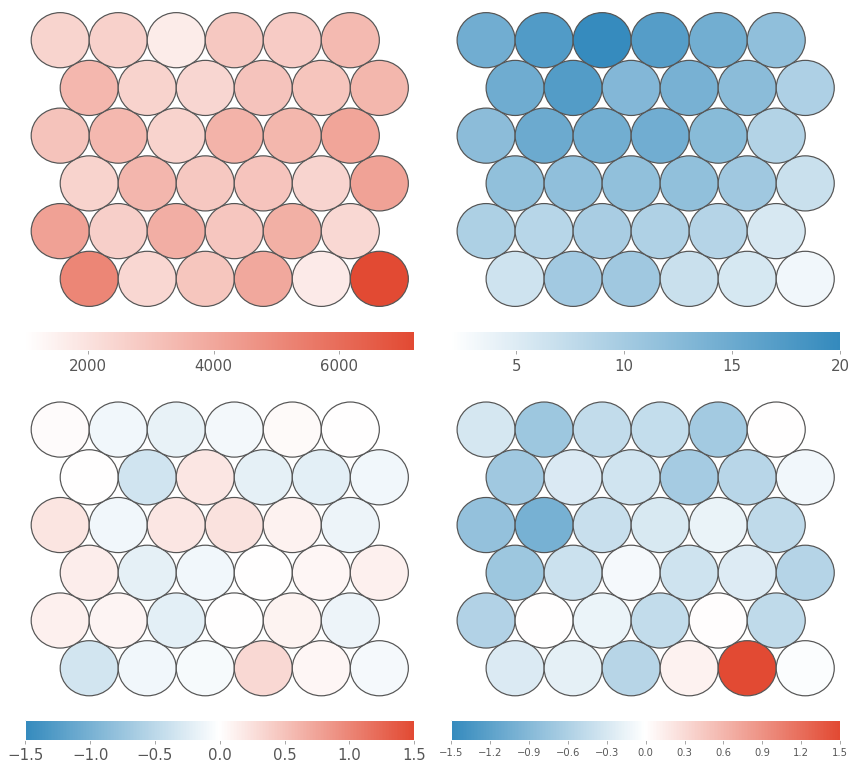

In [33]:
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib_helper as mc

#create axis and gridspec
fig, axes = plt.subplots(figsize=(12, 11), ncols=2, nrows=2)

#create cluster size SOM
cluster_size = np.asarray([
        len(g4_data[g4_data.cluster==n]) for n in range(x_nodes*y_nodes)])
cm1 = LinearSegmentedColormap.from_list('mc_blue', [(0, 'white'),
                                                    (1, mc.red)])
color_range = (1000, cluster_size.max())
sm1 = ScalarMappable(Normalize(*color_range), cmap=cm1)
sm1.set_array(cluster_size)

for size, xy in zip(cluster_size, grid):
    cluster_circle = Circle(xy, radius=0.5,
                            facecolor=sm1.to_rgba(size),
                            edgecolor='#555555', lw=1.2)
    axes[0][0].add_patch(cluster_circle)
axes[0][0].set(xlim=(grid[:,0].min()-0.6, grid[:,0].max()+0.6),
               ylim=(grid[:,1].min()-0.6, grid[:,1].max()+0.6))
axes[0][0].set_axis_off()

cbar = plt.colorbar(sm1, orientation='horizontal', ax=axes[0][0], pad=0.05)
cbar.set_ticks([0, 2000, 4000, 6000, 8000])
cbar.ax.tick_params(labelsize=15) 

#create loop length SOM
loop_length_means = np.asarray([
    g4_data[g4_data.cluster==n].total_loop_length.mean() for n in range(
            x_nodes*y_nodes)])

cm1 = LinearSegmentedColormap.from_list('mc_blue', [(0, 'white'),
                                                    (1, mc.blue)])
color_range = (2, 20)
sm1 = ScalarMappable(Normalize(*color_range), cmap=cm1)
sm1.set_array(loop_length_means)

for length, xy in zip(loop_length_means, grid):
    cluster_circle = Circle(xy, radius=0.5,
                            facecolor=sm1.to_rgba(length),
                            edgecolor='#555555', lw=1.2)
    axes[0][1].add_patch(cluster_circle)
axes[0][1].set(xlim=(grid[:,0].min()-0.6, grid[:,0].max()+0.6),
            ylim=(grid[:,1].min()-0.6, grid[:,1].max()+0.6))
axes[0][1].set_axis_off()

#create colorbar for loop length
cbar = plt.colorbar(sm1, orientation='horizontal', ax=axes[0][1], pad=0.05)
cbar.set_ticks([0, 5, 10, 15, 20])
cbar.ax.tick_params(labelsize=15) 

#create downreg template SOM
cm2 = LinearSegmentedColormap.from_list('mc_bwr', [(0, mc.blue),
                                                   (0.5, 'white'),
                                                   (1, mc.red)])
color_range = (-1.5, 1.5)
sm2 = ScalarMappable(Normalize(*color_range), cmap=cm2)
sm2.set_array(downreg_template_g4_enrichment)

for enrich, xy in zip(downreg_coding_g4_enrichment, grid):
    cluster_circle = Circle(xy, radius=0.5,
                            facecolor=sm2.to_rgba(enrich),
                            edgecolor='#555555', lw=1.2)
    axes[1][0].add_patch(cluster_circle)
axes[1][0].set(xlim=(grid[:,0].min()-0.6, grid[:,0].max()+0.6),
            ylim=(grid[:,1].min()-0.6, grid[:,1].max()+0.6))
axes[1][0].set_axis_off()

#create colorbar for enrichment
cbar = plt.colorbar(sm2, orientation='horizontal', ax=axes[1][0], pad=0.05)
cbar.set_ticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
cbar.ax.tick_params(labelsize=15) 

for enrich, xy in zip(downreg_template_g4_enrichment, grid):
    cluster_circle = Circle(xy, radius=0.5,
                            facecolor=sm2.to_rgba(enrich),
                            edgecolor='#555555', lw=1.2)
    axes[1][1].add_patch(cluster_circle)
axes[1][1].set(xlim=(grid[:,0].min()-0.6, grid[:,0].max()+0.6),
            ylim=(grid[:,1].min()-0.6, grid[:,1].max()+0.6))
axes[1][1].set_axis_off()

plt.colorbar(sm2, orientation='horizontal', ax=axes[1][1], pad=0.05)

plt.tight_layout()
plt.savefig('./som_plots_clustersize_loop_length_downreg_temp_coding_enrich.pdf')
plt.savefig('./som_plots_clustersize_loop_length_downreg_temp_coding_enrich.svg')
plt.savefig('./som_plots_clustersize_loop_length_downreg_temp_coding_enrich.png')
plt.show()

In [30]:
list(zip(grid, downreg_template_g4_enrichment, loop_length_means))

[(array([ 1.5      ,  0.8660254]), -0.26303440583379378, 6.3685436893203882),
 (array([ 2.5      ,  0.8660254]), -0.1970368470595536, 10.289640591966174),
 (array([ 3.5      ,  0.8660254]), -0.53051471669877981, 10.421885521885521),
 (array([ 4.5      ,  0.8660254]), 0.11247472925841266, 6.811349306431274),
 (array([ 5.5      ,  0.8660254]), 1.6334028557789093, 5.5878220140515227),
 (array([ 6.5      ,  0.8660254]), -0.031708859727338147, 3.2583066870568609),
 (array([ 1.        ,  1.73205081]), -0.5693656456701377, 9.2841555977229593),
 (array([ 2.        ,  1.73205081]), 0.0, 8.3382352941176467),
 (array([ 3.        ,  1.73205081]), -0.14937762403822669, 9.6104928457869629),
 (array([ 4.        ,  1.73205081]), -0.44745897697122144, 9.1314363143631443),
 (array([ 5.        ,  1.73205081]), 0.015430040569605969, 8.5593356549691944),
 (array([ 6.        ,  1.73205081]), -0.47804729680464425, 5.5422715627668655),
 (array([ 1.5       ,  2.59807621]), -0.72128397193393656, 11.758429194763

In [21]:
%%R -i downreg_template_scaled,downreg_coding_scaled,scale_min,scale_max,upreg_template_scaled,upreg_coding_scaled
color.bar <- function(lut, min, max=-min, nticks=11, ticks=seq(min, max, len=nticks), title='') {
    scale = (length(lut)-1)/(max-min)
    plot(c(0,1), c(min,max), type='n', bty='n', xaxt='n', xlab='', yaxt='n', ylab='', main=title)
    axis(2, ticks, at=round(scale_min):round(scale_max), labels=NULL, las=1)
    for (i in 1:(length(lut)-1)) {
     y = (i-1)/scale + min
     rect(0,y,10,y+1/scale, col=lut[i], border=NA)
    }
}

col <- colorRampPalette(c("red","gray","blue"))(100)
plot(g4_data.som, type='mapping', bgcol=col[downreg_template_scaled],
     main='G4 clusters enriched / depleted in genes downreg by NMM, -ve strand')
plot(g4_data.som, type='mapping', bgcol=col[downreg_coding_scaled],
     main='G4 clusters enriched / depleted in genes downreg by NMM, +ve strand')
plot(g4_data.som, type='mapping', bgcol=col[upreg_template_scaled],
     main='G4 clusters enriched / depleted in genes upreg by NMM, -ve strand')
plot(g4_data.som, type='mapping', bgcol=col[upreg_coding_scaled],
     main='G4 clusters enriched / depleted in genes upreg by NMM, +ve strand')
color.bar(col, min=scale_min, max=scale_max)

NameError: name 'downreg_template_scaled' is not defined